# Conditional Median Inference Simulations

This notebook replicates the simulations seen in Section 4 of [1]. Specifically, it tests the performance of the general Conditional Quantile Inference algorithm (Algorithm 2) on 3 distributions with 4 different conformity scores. There are 4 sections:


1.   **Distributions** - Describes the distribution class and covers the 3 relevant distributions
2.   **Conformity Scores** - Describes the conformity score class and covers the 4 relevant scores
3.   **Conditional Quantile Algorithm** - Contains an implementation of Algorithm 2
4.   **Testing Algorithm Performance** - Tests algorithm performance given each combination of distribution and conformity score



[1] Dhruv Medarametla and Emmanuel Candès, "Distribution-Free Conditional Median Inference." 2021.

In [ ]:
!pip install scikit-garden

     |████████████████████████████████| 317kB 5.0MB/s 
  Created wheel for scikit-garden: filename=scikit_garden-0.1.3-cp36-cp36m-linux_x86_64.whl size=665224 sha256=8c739d126bb6c621a069e93a8dfaf4938c956e569030713c248aaa28eede9e39
  Stored in directory: /root/.cache/pip/wheels/d0/ef/71/3a032ba9a2b70690c9f9ec2e383afee6610f509af312ff2cf3
Successfully built scikit-garden


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
from sklearn.utils import shuffle
import pickle
import tqdm

# Used to save images to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

from skgarden import RandomForestQuantileRegressor, RandomForestRegressor


Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

# Distributions

This section contains different distributions that can be passed into the conditional quantile inference algorithm to test performance. Each distribution contains a sampling method and a conditional quantile calculation method.

### Distribution 1

In [ ]:
class NormalCorrelatedDistribution:

  def __init__(self, d = 3, rho = 0, sigma = 1):
    assert d >= 3, f"Need d at least 3 but got {d}"
    self.mu = np.zeros(d)
    self.Sigma = (1. - rho) * np.identity(d) + rho * np.ones((d,d))
    self.resid_sigma = sigma

  def get_stdev(self, X, n):
    return 0.1 + 0.25 * np.square(np.linalg.norm(X, axis = 1)).reshape((n,1))

  def sample(self, n):
    X = np.random.multivariate_normal(mean = self.mu, cov = self.Sigma, size = n)
    Y_mean = np.square(X[:,[0]] + X[:,[1]]) - X[:,[2]]
    Y_resid = np.multiply(self.get_stdev(X, n), np.random.normal(loc = 0., scale = self.resid_sigma, size = (n,1)))
    Y = Y_mean + Y_resid
    return X, Y

  def get_quantile(self, X, q):
    Y_mean = np.square(X[:,[0]] + X[:,[1]]) - X[:,[2]]
    Y_quantile = self.get_stdev(X, X.shape[0]) * norm.ppf(q, loc = 0., scale = self.resid_sigma)
    return Y_mean + Y_quantile

### Distribution 2

In [ ]:
class IncreasingVarianceDistribution:

  def __init__(self, scale = np.pi, power = 1.):
    assert scale > 0, f"Need positive scale but got {scale}"
    assert power > 0, f"Need positive power but got {power}"
    self.scale = scale
    self.power = power

  def f(self, X):
    return 1 + np.abs(X) * np.square(np.sin(X))

  def sample(self, n):
    X = np.random.uniform(low = -1. * self.scale, high = self.scale, size = (n,1))
    Y = self.f(X) * (np.random.uniform(low = 0., high = 1., size = (n,1)) ** self.power)
    return X, Y

  def get_quantile(self, X, q):
    return self.f(X) * (np.full(shape = (X.shape[0], 1), fill_value = q) ** self.power)


### Distribution 3

In [ ]:
class ConfusingDistribution:

  def __init__(self, delta = 0.01, M = 10):
    assert delta > 0 and delta <= 0.25, f"Need delta in (0, 0.25] but got {delta}"
    assert isinstance(M, int) and M > 0, f"Need M to be a positive integer but got {M}"
    self.delta = delta
    self.M = M
    self.gamma = 1. / M

  def f(self, X):
    integral_part, fractional_part = np.divmod(X * self.M, 1.)
    return self.gamma * fractional_part - self.gamma / 2. - ((-1) ** (integral_part)) * (1. - self.gamma / 2.)

  def sample(self, n):
    X = np.random.uniform(low = -1., high = 1., size = (n,1))
    Y = self.f(X) * np.random.binomial(n = 1, p = 0.5 + 2 * self.delta, size = (n,1))
    return X, Y

  def get_quantile(self, X, q):
    nonzero_values = self.f(X)
    return (np.sign(nonzero_values) * (q - 0.5) >= -2. * self.delta) * nonzero_values


## Distribution Plots

We plot the distributions, as well as the conditional medians, of Distributions 2 and 3. For Distribution 1, we cannot plot the full distribution due to dimensionality; we instead plot the distribution of the datapoints as well as the distribution of the conditional median.

In [ ]:
n = 10000
q = 0.5

bins = 150

save_figs = False
images_dir = '/content/gdrive/My Drive/Conditional Median Inference/'
dpi = 2000

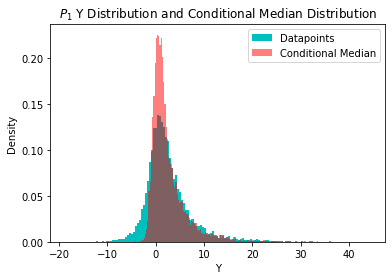

In [ ]:
distribution1 = NormalCorrelatedDistribution(d = 10, rho = 0.25, sigma = 1)
X, Y = distribution1.sample(n)
Y_median = distribution1.get_quantile(X, q)

plt.hist(Y, density = True, bins = bins, alpha = 1, color = 'c', label = 'Datapoints')
plt.hist(Y_median, density = True, bins = bins, alpha = 0.5, color = 'r', label = 'Conditional Median')
plt.legend()
plt.xlabel('Y')
plt.ylabel('Density')
plt.title(r'$P_1$ Y Distribution and Conditional Median Distribution')

if save_figs:
  filename = "Distribution 1.pdf"
  plt.savefig(images_dir + filename)
plt.show()

In [ ]:
datapoint_size = 5
datapoint_color = 'c'
datapoint_scale = 2.

median_linewidth = 2
median_color = 'k'

title_fontsize = 16
label_fontsize = 14

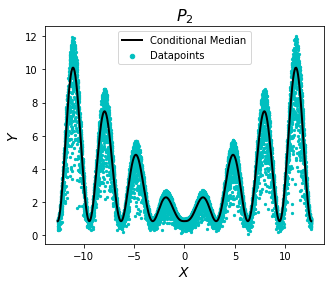

In [ ]:
scale = 4 * np.pi
power = 0.25

distribution2 = IncreasingVarianceDistribution(scale = scale, power = power)
X, Y = distribution2.sample(n)

X_range = np.linspace(start = -1. * scale, stop = scale, num = n)
Y_median = distribution2.get_quantile(X_range.reshape((n,1)), 0.5)

plt.figure(figsize = (5,4))
plt.tight_layout()
plt.scatter(X,Y, s = datapoint_size, color = datapoint_color, label = 'Datapoints')
plt.plot(X_range, Y_median, color = median_color, linewidth = median_linewidth, label = 'Conditional Median')
plt.legend(markerscale= datapoint_scale)

plt.xlabel(r"$X$", fontsize = label_fontsize)
plt.ylabel(r"$Y$", fontsize = label_fontsize)
plt.title(r"$P_2$", fontsize = title_fontsize)

save_figs = True
if save_figs:
  filename = "Distribution 2.pdf"
  plt.savefig(images_dir + filename,bbox_inches='tight')

plt.show()

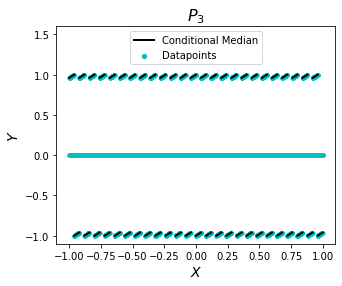

In [ ]:
M = 25
delta = 0.0001
gamma = 1./M

distribution3 = ConfusingDistribution(delta = delta, M = M)
X, Y = distribution3.sample(n)

plt.figure(figsize = (5,4))
plt.tight_layout()
plt.scatter(X,Y, s = 8, color = datapoint_color, label = 'Datapoints')
plt.plot([0, 0], [-1, -1], color = median_color, linewidth = median_linewidth, label = 'Conditional Median')

for i in range(-M, M):
  if (i % 2) == 0:
    plt.plot([gamma * i, gamma * i + gamma], [-1, -1 + gamma], color = median_color, linewidth = median_linewidth)
  if (i % 2) == 1:
    plt.plot([gamma * i, gamma * i + gamma], [1 - gamma, 1], color = median_color, linewidth = median_linewidth)


plt.ylim((-1.1, 1.6))
plt.legend(markerscale= 1.5, loc = 'upper center')

plt.xlabel(r"$X$", fontsize = label_fontsize)
plt.ylabel(r"$Y$", fontsize = label_fontsize)
plt.title(r"$P_3$", fontsize = title_fontsize)

save_figs = True
if save_figs:
  filename = "Distribution 3.pdf"
  plt.savefig(images_dir + filename,bbox_inches='tight')

plt.show()

# Conformity Scores

This section contains different conformity scores that can be passed into the conditional median inference algorithm. Each score contains a training method, a scoring method, and an inverse method. Note that we use a random forest predictor for all 4 conformity scores; for the first two, we train a random forest to predict the conditional mean, while the last two train a random forest to predict the conditional quantile.

### Conformity Score 1

In [ ]:
class LinearDistanceConformityScore:

  def __init__(self, **kwargs):
    self.mu = RandomForestRegressor(**kwargs)

  def train(self, X, Y):
    self.mu.fit(X, Y)

  def score(self, X, Y):
    n = X.shape[0]
    prediction = self.mu.predict(X).reshape((n,1))
    return Y - prediction

  def inverse(self, X, score):
    n = X.shape[0]
    prediction = self.mu.predict(X).reshape((n,1))
    return prediction + score


### Conformity Score 2

In [ ]:
class NormalizedDistanceConformityScore: 

  def __init__(self, **kwargs):
    self.mu = RandomForestRegressor(**kwargs)

  def train(self, X, Y):
    self.mu.fit(X, Y)

  def score(self, X, Y):
    n = X.shape[0]
    prediction, std = self.mu.predict(X, return_std = True)
    prediction = prediction.reshape((n,1))
    std = std.reshape((n,1))
    return (Y - prediction) / std

  def inverse(self, X, score):
    n = X.shape[0]
    prediction, std = self.mu.predict(X, return_std = True)
    prediction = prediction.reshape((n,1))
    std = std.reshape((n,1))
    return prediction + score * std


### Conformity Score 3

In [ ]:
class QuantileDistanceConformityScore:

  def __init__(self, quantile = None, **kwargs):
    self.mu = RandomForestQuantileRegressor(**kwargs)
    self.quantile = 100 * quantile

  def train(self, X, Y):
    self.mu.fit(X, Y)

  def score(self, X, Y):
    n = X.shape[0]
    prediction = self.mu.predict(X, quantile = self.quantile).reshape((n,1))
    return Y - prediction

  def inverse(self, X, score):
    n = X.shape[0]
    prediction = self.mu.predict(X, quantile = self.quantile).reshape((n,1))
    return prediction + score


### Conformity Score 4

In [ ]:
class InverseCDFConformityScore:

  quantile_list = [0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,95,96,97,98,99,100]

  def __init__(self, quantiles = None, **kwargs):
    self.mu = RandomForestQuantileRegressor(**kwargs)
    if quantiles:
      self.quantiles = quantiles
    else:
      self.quantiles = self.quantile_list

  def train(self, X, Y):
    self.mu.fit(X, Y)

  def score_individual(self, X_i, Y_i):
    Y_value = Y_i[0,0]
    quantile_predictions = {}

    low_index = 0
    high_index = len(self.quantiles) - 1
    mid_index = 0

    while low_index + 1 < high_index:
      mid_index = int((low_index + high_index) / 2)
      mid_value = self.quantiles[mid_index]
      quantile_predictions[mid_value] = self.mu.predict(X_i, quantile = mid_value)[0]

      if quantile_predictions[mid_value] < Y_value:
        low_index = mid_index
      elif quantile_predictions[mid_value] > Y_value:
        high_index = mid_index
      else:
        return mid_value

    low_value = self.quantiles[low_index]
    high_value = self.quantiles[high_index]
    if low_value not in quantile_predictions:
      quantile_predictions[low_value] = self.mu.predict(X_i, quantile = low_value)[0]
    if high_value not in quantile_predictions:
      quantile_predictions[high_value] = self.mu.predict(X_i, quantile = high_value)[0]

    if Y_value < quantile_predictions[low_value]:
      return self.quantiles[0] + Y_value - quantile_predictions[low_value]
    if Y_value > quantile_predictions[high_value]:
      return self.quantiles[-1] + Y_value - quantile_predictions[high_value]
    return np.interp(Y_value, [quantile_predictions[low_value], quantile_predictions[high_value]], [low_value, high_value])

  def score(self, X, Y):
    n = X.shape[0]
    scores = np.zeros((n, 1))

    for i in range(n):
      X_i = X[[i],:]
      Y_i = Y[[i],:]
      scores[i, 0] = self.score_individual(X_i, Y_i)
    return scores

  def inverse_individual(self, X_i, score_i):
    score_value = score_i[0,0]
    quantile_predictions = {}

    if score_value < self.quantiles[0]:
      quantile_predictions[self.quantiles[0]] = self.mu.predict(X_i, quantile = self.quantiles[0])[0]
      return quantile_predictions[self.quantiles[0]] + score_value - self.quantiles[0]
    if score_value > self.quantiles[-1]:
      quantile_predictions[self.quantiles[-1]] = self.mu.predict(X_i, quantile = self.quantiles[-1])[0]
      return quantile_predictions[self.quantiles[-1]] + score_value - self.quantiles[-1]

    low_index = np.searchsorted(self.quantiles, score_value, side = 'right') - 1
    high_index = np.searchsorted(self.quantiles, score_value, side = 'left')
    low_value = self.quantiles[low_index]
    high_value = self.quantiles[high_index]
    if low_value not in quantile_predictions:
      quantile_predictions[low_value] = self.mu.predict(X_i, quantile = low_value)[0]
    if high_value not in quantile_predictions:
      quantile_predictions[high_value] = self.mu.predict(X_i, quantile = high_value)[0]
    return np.interp(score_value, [low_value,high_value], [quantile_predictions[low_value], quantile_predictions[high_value]])
  
  def inverse(self, X, score):
    n = X.shape[0]
    inverses = np.zeros((n, 1))

    for i in range(n):
      X_i = X[[i],:]
      score_i = score[[i],:]
      inverses[i, 0] = self.inverse_individual(X_i, score_i)
    return inverses


# Conditional Quantile Algorithm

This section contains the conditional quantile algorithm (Algorithm 2). It contains a train and test method.

In [ ]:
class ConditionalMedianAlgorithm:

  def __init__(self, conformity_score_low, conformity_score_high, 
               alpha = 0.1, quantile = 0.5, 
               data_split_proportion = 0.5, probability_split_proportion = 0.5):
    
    assert alpha > 0 and alpha < 1, f"Need alpha to be in (0,1) but got {alpha}"
    assert quantile > 0 and quantile < 1, f"Need quantile to be in (0,1) but got {quantile}"
    assert data_split_proportion > 0 and quantile < 1, f"Need data_split_proportion to be in (0,1) but got {data_split_proportion}"
    assert probability_split_proportion > 0 and probability_split_proportion < 1, f"Need probability_split_proportion to be in (0,1) but got {probability_split_proportion}"


    self.f_lo = conformity_score_low
    self.f_hi = conformity_score_high
    self.alpha = alpha
    self.q = quantile
    self.data_split_proportion = data_split_proportion
    self.probability_split_proportion = probability_split_proportion

    self.r = alpha * probability_split_proportion
    self.s = alpha * (1. - probability_split_proportion)

  def train(self, X, Y):
    n = X.shape[0]
    assert Y.shape[0] == n, f"Need X and Y to be 2-dimensional arrays with equal number of rows but got X.shape={X.shape} and Y.shape={Y.shape}"

    n_1 = int(n * self.data_split_proportion)
    n_2 = n - n_1
    X_shuffled, Y_shuffled = shuffle(X, Y)
    X_I_1 = X_shuffled[:n_1, :]
    X_I_2 = X_shuffled[n_1:, :]
    Y_I_1 = Y_shuffled[:n_1, :]
    Y_I_2 = Y_shuffled[n_1:, :]

    self.f_lo.train(X_I_1, Y_I_1)
    self.f_hi.train(X_I_1, Y_I_1)

    f_lo_scores = self.f_lo.score(X_I_2, Y_I_2).flatten()
    f_hi_scores = self.f_hi.score(X_I_2, Y_I_2).flatten()

    lower_quantile = self.r * self.q * (1. + 1. / n_2) - 1. / n_2
    upper_quantile = (1 - self.s * (1 - self.q)) * (1. + 1. / n_2)

    self.lower_score_bound = np.quantile(f_lo_scores, lower_quantile)
    self.upper_score_bound = np.quantile(f_hi_scores, upper_quantile)

  def test(self, X):
    n = X.shape[0]
    CI_lower = self.f_lo.inverse(X, np.full((n, 1), fill_value = self.lower_score_bound))
    CI_upper = self.f_hi.inverse(X, np.full((n, 1), fill_value = self.upper_score_bound))
    return np.concatenate((CI_lower, CI_upper), axis = 1)


# Testing Algorithm Performance

We now go over the performance of the Conditional Median Algorithm by testing its performance on different distributions and conformity scores.

### Helper Functions

In [ ]:
def get_indices_accurate(values, CI):
  return np.logical_and(np.less_equal(CI[:,[0]], values), np.less_equal(values, CI[:,[1]]))

def get_proportion_accurate(values, CI):
  return np.average(get_indices_accurate(values, CI))

def get_widths(CI):
  return CI[:,[1]] - CI[:,[0]]

def get_avg_width(CI):
  return np.average(get_widths(CI))

### Distribution Parameter Specifications

In [ ]:
def get_dist(distribution):
  if distribution == 1:
    return NormalCorrelatedDistribution(d = 10, rho = 0.25, sigma = 1)
  if distribution == 2:
    return IncreasingVarianceDistribution(scale = 4 * np.pi, power = 0.25)
  if distribution == 3:
    return ConfusingDistribution(delta = 0.0001, M = 25)
  assert f"Need distribution to be 1, 2, or 3, but got {distribution}"

### Distribution Test Points

In [ ]:
dist_1_test_data = NormalCorrelatedDistribution(d = 10, rho = 0.25, sigma = 1).sample(50000)[0]

def get_test_dist(distribution, n):
  if distribution == 1:
    return dist_1_test_data[:n, :]
  if distribution == 2:
    return np.linspace(start = -4. * np.pi, stop = 4 * np.pi, num = n).reshape((n, 1))
  if distribution == 3:
    return np.linspace(start = -1., stop = 1., num = n).reshape((n, 1))
  assert f"Need distribution to be 1, 2, or 3, but got {distribution}"

### Random Forest Hyperparameters

In [ ]:
kwargs = {"n_estimators": 20,
          "min_samples_split": 80,
          "min_samples_leaf": 40}

def get_scores(score, alpha):
  if score == 1:
    return LinearDistanceConformityScore(**kwargs), LinearDistanceConformityScore(**kwargs)
  if score == 2:
    return NormalizedDistanceConformityScore(**kwargs), NormalizedDistanceConformityScore(**kwargs)
  if score == 3:
    return QuantileDistanceConformityScore(quantile = alpha/2., criterion = "mae", **kwargs), QuantileDistanceConformityScore(quantile = 1. - alpha/2., criterion = "mae", **kwargs)
  if score == 4:
    return InverseCDFConformityScore(quantiles = None, criterion = "mae", **kwargs), InverseCDFConformityScore(quantiles = None, criterion = "mae", **kwargs)
  assert f"Need score to be 1, 2, 3, or 4, but got {score}"

### Simulation Parameters

In [ ]:
alpha = 0.1
n_train = 5000
n_test = 5000

In [ ]:
def run_singular_trial(distribution_number, score_number, make_fig = True, save_fig = False, trial_num = 0, print_stats = False):
  setup = f"Distribution {distribution_number}; Conformity Score {score_number}; Trial {trial_num}"
  print(setup)
  dist = get_dist(distribution_number)

  f_lo, f_hi = get_scores(score_number, alpha = alpha)

  algorithm = ConditionalMedianAlgorithm(conformity_score_low = f_lo, conformity_score_high = f_hi, alpha = alpha)

  X_train, Y_train = dist.sample(n_train)
  algorithm.train(X_train, Y_train)

  X_test = get_test_dist(distribution_number, n_test)
  Y_median_true = dist.get_quantile(X_test, 0.5)
  Y_median_CI = algorithm.test(X_test)
  prop_accurate = get_proportion_accurate(Y_median_true, Y_median_CI)
  avg_width = get_avg_width(Y_median_CI)

  if print_stats:
    print(f"Proportion Accurate: {prop_accurate}")
    print(f"Average Width: {avg_width}")

  if make_fig and distribution_number in [2,3]:
    plt.figure(figsize = (5,4))
    plt.tight_layout()
    plt.plot(X_test, Y_median_true, color = median_color, linewidth = median_linewidth, label = 'Conditional Median')
    plt.fill_between(X_test.ravel(), Y_median_CI[:,[0]].ravel(), Y_median_CI[:,[1]].ravel(), label = 'Confidence Interval', color = 'r', alpha = 0.2)
    plt.scatter(X_train, Y_train, s = 0.5, color = datapoint_color, alpha = 0.25, label = 'Datapoints')
    plt.legend(markerscale = 5)

    plt.xlabel(r"$X$", fontsize = label_fontsize)
    plt.ylabel(r"$Y$", fontsize = label_fontsize)
    plt.title(f"Conformity Score {score_number}", fontsize = title_fontsize)
    if save_fig:
      filename = f"{setup}.{trial_num}.pdf"
      plt.savefig(images_dir + filename,bbox_inches='tight')
    plt.show()

  return get_indices_accurate(Y_median_true, Y_median_CI), get_widths(Y_median_CI)

## Get Images of Singular Trial on Distribution 2 for all conformity scores

In [ ]:
distribution_number = 2

for score_number in tqdm.tqdm([1,2,3,4]):
  indices_acc, widths = run_singular_trial(distribution_number, score_number, make_fig = True, save_fig = True, trial_num = 0)

  prop_accurate = np.average(indices_acc)
  avg_width = np.average(widths)
  performance = {"Proportion Accurate": prop_accurate,
                "Average Width": avg_width}
  output = open(images_dir + f"Performance Distribution {distribution_number} Score {score_number}.pkl", 'wb')
  pickle.dump(performance, output)
  output.close()

## Run 25 trials for each combination of distribution and conformity score to test performance

In [ ]:
num_trials = 25

In [ ]:
for dist_number in [1,2,3]:
  for score_number in [1,2,3,4]:

    conditional_accuracies = []
    conditional_widths = []

    for trial in range(num_trials):
      indices_acc, widths = run_singular_trial(distribution_number, score_number, make_fig = False, save_fig = False, trial_num = trial + 1)
      conditional_accuracies.append(indices_acc)
      conditional_widths.append(widths)

    cond_acc_table = np.concatenate(conditional_accuracies, axis = 1)
    cond_width_table = np.concatenate(conditional_widths, axis = 1)

    coverage_prob = np.mean(cond_acc_table)
    min_cond_coverage = min(np.mean(cond_acc_table, axis = 1))
    avg_ci_width = np.mean(cond_width_table)
    print(f"Coverage Probability: {coverage_prob}")
    print(f"Minimum Conditional Coverage: {min_cond_coverage}")
    print(f"Average CI Width: {avg_ci_width}")

    results = {"Conditional Accuracies": cond_acc_table,
              "Confidence Interval Widths": cond_width_table,
              "Coverage Probability": coverage_prob,
              "Minimum Conditional Coverage": min_cond_coverage,
              "Average CI Width": avg_ci_width}

    output = open(images_dir + f"Results Distribution {distribution_number} Score {score_number}.pkl", 'wb')
    pickle.dump(results, output)
    output.close()
  


## Calculating Simulation Metrics 

We calculate the average rate of coverage, the standard deviation of rate of coverage, the minimal conditional coverage, the average confidence interval width, and the standard deviation of average confidence interval width.

In [ ]:

coverage_stdev_table = np.zeros((4,3))
cond_stdev_table = np.zeros((4,3))

width_stdev_table = np.zeros((4,3))
cond_width_stdev_table = np.zeros((4,3))

In [ ]:
for dist_num in [1,2,3]:
  for score_num in [1,2,3,4]:
    indices = (score_num - 1, dist_num - 1)

    print(f"Distribution {dist_num}; Conformity Score {score_num}")
    with open(images_dir + f"Results Distribution {dist_num} Score {score_num}.pkl", 'rb') as handle:
        results = pickle.load(handle)
        
    trial_accuracies = np.mean(results['Conditional Accuracies'], axis = 0)
    trial_acc_stdev = np.std(trial_accuracies, ddof=1)
    cond_accuracies = np.mean(results['Conditional Accuracies'], axis = 1)
    cond_acc_stdev = np.std(cond_accuracies, ddof=1)

    results["Coverage StDev"] = coverage_stdev_table[indices] = trial_acc_stdev
    results["Conditional Coverage StDev"] = cond_stdev_table[indices] = cond_acc_stdev
    print(f"Coverage StDev: {trial_acc_stdev}")
    print(f"Conditional Coverage StDev: {cond_acc_stdev}")

    trial_widths = np.mean(results['Confidence Interval Widths'], axis = 0)
    trial_width_stdev = np.std(trial_widths, ddof = 1)
    cond_widths = np.mean(results['Confidence Interval Widths'], axis = 1)
    cond_width_stdev = np.std(cond_widths, ddof = 1)

    results["Avg Width StDev"] = width_stdev_table[indices] = trial_width_stdev
    results["Conditional Avg Width StDev"] = cond_width_stdev_table[indices] = cond_width_stdev
    print(f"Average Width StDev: {trial_width_stdev}")
    print(f"Conditional Average Width StDev: {cond_width_stdev}")


    output = open(images_dir + f"Results Extended Distribution {distribution_number} Score {score_number}.pkl", 'wb')
    pickle.dump(results, output)
    output.close()
      

Distribution 1; Conformity Score 1
Coverage StDev: 0.0019171854370404545
Conditional Coverage StDev: 0.08190582817442106
Average Width StDev: 0.432797735144035
Conditional Average Width StDev: 0.0990325678337934
Distribution 1; Conformity Score 2
Coverage StDev: 0.000936874235601197
Conditional Coverage StDev: 0.030887638842207563
Average Width StDev: 0.40002104116493803
Conditional Average Width StDev: 4.962640562725247
Distribution 1; Conformity Score 3
Coverage StDev: 0.0012649110640673559
Conditional Coverage StDev: 0.035328402443414286
Average Width StDev: 0.3218379593125384
Conditional Average Width StDev: 3.7719437195885344
Distribution 1; Conformity Score 4
Coverage StDev: 0.0008549463920815996
Conditional Coverage StDev: 0.02698721471274111
Average Width StDev: 0.45798653510426357
Conditional Average Width StDev: 4.463805431134346
Distribution 2; Conformity Score 1
Coverage StDev: 0.001966655367199182
Conditional Coverage StDev: 0.010662971621117564
Average Width StDev: 0.1674